In [102]:
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
plt.rcParams['svg.fonttype'] = 'none'
import seaborn as sns



In [2]:
# colors and class-superclass maps
with open(r'..\data\metadata\color_schemes.json') as infile:
    colors = json.load(infile)

animals_used = [1091, 1093, 1060, 1062, 1074, 1092, 1102, 1076, 1082, 1101]
diabetic =     [1076, 1082, 1101]
impaired =     [1060, 1062, 1074, 1092, 1102]
normal =       [1091, 1093]
animal_tol = {
    1076: 'diabetic', 1082: 'diabetic', 1101: 'diabetic', 1060: 'impaired', 1062: 'impaired', 
    1074: 'impaired', 1092: 'impaired', 1102: 'impaired', 1091: 'normal', 1093: 'normal'}
ap = pd.read_excel(r'..\data\metadata\animal_phenotypes.xlsx', index_col=0)
fg = pd.read_csv(r'..\data\metadata\combined_metab_lipid_file_grouping.csv', index_col=0)

# Use data that was sent to collaborators 
data = pd.read_csv(r'..\data\processed\combined_metabolites_data_with_model_params.csv').set_index('i')
data_cols = data.filter(regex='_FBG|_RBG').columns
fbg_cols = data.filter(regex='_FBG').columns
rbg_cols = data.filter(regex='_RBG').columns

qval_sampling = data['qval_sampling']
qval_gtol = data['qval_ogtt']
qval_cross = data['qval_sampling:ogtt']

In [3]:
ogtt_values = ap.loc[ap['lcms_sampled'], 'OGTT (AUC)']
min_ogtt, max_ogtt = min(ogtt_values), max(ogtt_values)

def parse_pval(pval):
    if pval < 0.0001:
        return '****'
    if pval < 0.001:
        return '***'
    if pval < 0.01:
        return '**'
    if pval < 0.05: 
        return '*'
    else:
        return 'ns'

<AxesSubplot:xlabel='OGTT (AUC)', ylabel='log2 quant.'>

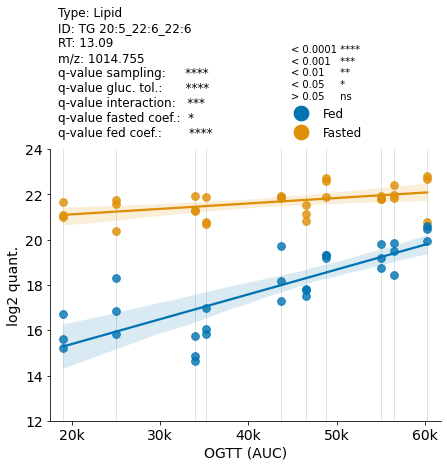

In [10]:
def plot_quant_vs_ogtt(
    feature, data, 
    ax=None, include_info=False, savefig=False, folder_path=None, file_type=None,
    figsize=(7, 5)):
    """
    Make pretty plot of metabolite quant vs. OGTT AUC.
    
    Option to include q-values or not with include_info param
    
    feature = 'l_762'
    data = the whole dataframe read in from the excel sheet
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize, facecolor='white')  
    df = data.loc[feature, data_cols].to_frame().join(fg[['ogtt', 'bg_type', 'animal']])
    df.rename({feature: 'quant'}, axis=1, inplace=True)
    df['quant'] = df['quant'].astype('float')
        
    for bg_type in ['FBG', 'RBG']:
        sns.regplot(
            data=df.loc[df['bg_type'] == bg_type], x='ogtt', y='quant', 
            color=colors[bg_type], n_boot=200,
            scatter_kws={'s': 60}, ax=ax, seed=1,)
    min_ogtt, max_ogtt = ap.loc[ap['lcms_sampled'], 'OGTT (AUC)'].min(), ap.loc[ap['lcms_sampled'], 'OGTT (AUC)'].max()
    ax.set_xlim(min_ogtt - 1500, max_ogtt + 1500)
    ax.set_xticks(np.arange(20000, 60001, 10000), labels=['20k', '30k', '40k', '50k', '60k'], fontsize=14)
    ax.set_xlabel('OGTT (AUC)', fontsize=14)
    ax.set_ylabel('log2 quant.', fontsize=14)
    ax.set_yticks(ax.get_yticks(), labels=[str(int(x)) for x in ax.get_yticks()], fontsize=14)
    animal_ogtts = ap.loc[ap['lcms_sampled'], 'OGTT (AUC)']
    for animal_ogtt in animal_ogtts:
        ax.axvline(animal_ogtt, c='gray', linewidth=0.8, alpha=0.3, zorder=-10)
    if include_info:    
        legend_title = '< 0.0001 ****\n< 0.001   ***\n< 0.01     **\n< 0.05     *\n> 0.05     ns'
        ax.legend(
            handles=[
                Line2D([0], [0], marker='o', color='w', label='Fed', markerfacecolor=colors['RBG'], markersize=14),
                Line2D([0], [0], marker='o', color='w', label='Fasted', markerfacecolor=colors['FBG'], markersize=14)],
            loc=(0.6, 1.02), title=legend_title, fontsize=12, ncol=1, frameon=False, markerscale=1.2)
        qvals = data.loc[feature, ['qval_sampling', 'qval_ogtt', 
                                   'qval_sampling:ogtt', 'qval_fasted', 'qval_fed']].to_list()
        _type = data.loc[feature, 'Type']
        unique_id = data.loc[feature, 'unique_id']
        _id = data.loc[feature, 'ID']
        rt = data.loc[feature, 'RT']
        mz = data.loc[feature, 'm/z']
        ax.text(x=0.02, y=0.98,
            s=f'Type: {_type.capitalize()}\n'
            f'ID: {_id}\nRT: {round(rt, 2)}\nm/z: {round(mz, 4)}\n'
            f'q-value sampling:     {parse_pval(qvals[0])}\n'  # round(qvals[0], 4)
            f'q-value gluc. tol.:      {parse_pval(qvals[1])}\n'  # round(qvals[1], 4)
            f'q-value interaction:   {parse_pval(qvals[2])}\n'   # round(qvals[2], 4)
            f'q-value fasted coef.:  {parse_pval(qvals[3])}\n'
            f'q-value fed coef.:       {parse_pval(qvals[4])}\n',
            fontsize=12, ha='left', va='bottom', transform=ax.transAxes)  
    sns.despine()
    if savefig:
        file_name = data.loc[feature, 'Type'] + '_' + str(rt) + '_' + str(mz)
        plt.savefig(f'{folder_path}/{file_name}.{file_type}', dpi=100, bbox_inches='tight', facecolor='white')
        plt.close()
    return ax

plot_quant_vs_ogtt(data=data, feature='l_525', include_info=True)

## Demonstration of `qval_sampling` in boxplot form

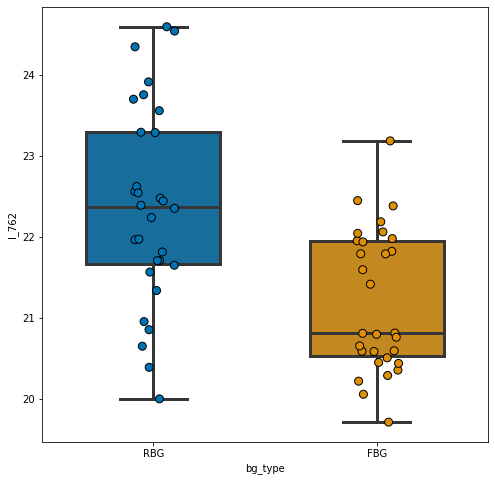

In [8]:
d = data.loc[:, data_cols].T.join(fg['bg_type'])
d['x'] = d['bg_type'].map({'RBG': 0, 'FBG': 1})
d

sns.boxplot(data=d,   y='l_762', x='bg_type', width=0.6, palette=colors, linewidth=3)
sns.stripplot(data=d,   y='l_762', x='bg_type', palette=colors, s=8, edgecolor='black', linewidth=1)
plt.gcf().set_size_inches(8, 8)

## Old style of plot using manual `get_model_params` and `sns.scatterplot`

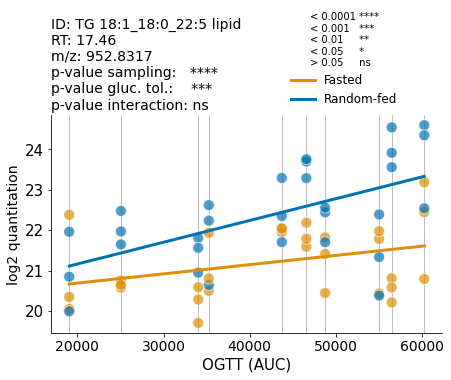

In [132]:
def make_fit_plot(feature, folder_path=None, file_type=None, savefig=False):
    fig, ax = plt.subplots(figsize=(7, 4))
#     feature = 'l_649'
    subset = data.loc[[feature], data_cols].T
    subset = subset.join(fg[['bg_type', 'ogtt']])
    sns.scatterplot(
        data=subset, x='ogtt', y=feature,          
        hue='bg_type', palette=colors, 
        s=120, alpha=0.7, legend=False,
        ax=ax)
    intercept, samp_rbg, ogtt, cross = data.loc[feature, data.filter(regex='model_par').columns]
    plt.plot(*get_model_params(feature, df=data)['FBG'], color=colors['FBG'], linewidth=3, label='Fasted')
    plt.plot(*get_model_params(feature, df=data)['RBG'], color=colors['RBG'], linewidth=3, label='Random-fed')
    for animal_ogtt in animal_ogtts:
        plt.axvline(animal_ogtt, c='gray', zorder=-10, linewidth=0.5)
    qvals = data.loc[feature, ['qval_sampling', 'qval_ogtt', 'qval_sampling:ogtt']].to_list()
    _type = data.loc[feature, 'Type']
    unique_id = data.loc[feature, 'unique_id']
    _id = data.loc[feature, 'ID']
    rt = data.loc[feature, 'RT']
    mz = data.loc[feature, 'm/z']
    plt.title(f'ID: {_id} {_type}\nRT: {round(rt, 2)}\nm/z: {round(mz, 4)}'
              f'\np-value sampling:   {parse_pval(qvals[0])}\n'  # round(qvals[0], 4)
              f'p-value gluc. tol.:    {parse_pval(qvals[1])}\n'  # round(qvals[1], 4)
              f'p-value interaction: {parse_pval(qvals[2])}',   # round(qvals[2], 4)
              fontsize=14, ha='left', loc='left')
    legend_title = '< 0.0001 ****\n< 0.001   ***\n< 0.01     **\n< 0.05     *\n> 0.05     ns'
    plt.legend(loc=(0.6, 1.02), title=legend_title, fontsize=12, ncol=1, frameon=False)
    plt.yticks(fontsize=15)
    plt.ylabel('log2 quantitation', fontsize=14)
    plt.xlabel('OGTT (AUC)', fontsize=15)
    plt.xticks(fontsize=14)
    sns.despine()
    if savefig:
        file_name = data.loc[feature, 'Type'] + '_' + str(rt) + '_' + str(mz)
        plt.savefig(f'{folder_path}/{file_name}.{file_type}', dpi=100, bbox_inches='tight', facecolor='white')
        plt.close()
        
        
make_fit_plot(feature='l_762', folder_path='../reports/figures/all_metabolite_plots')

## Old, obsolete plots below

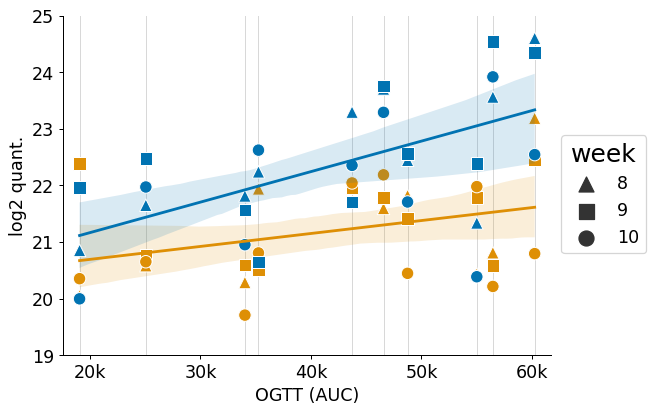

In [9]:
feature = 'l_762'
weekdf = data.loc[feature, data_cols].to_frame().join(fg[['bg_type', 'week', 'ogtt']])
weekdf[feature] = weekdf[feature].astype('float')
weekdf['week'] = weekdf['week'].astype('str')

fig, ax = plt.subplots(figsize=(7, 5), dpi=90)
for bg_type in ['FBG', 'RBG']:
    sns.regplot(
        data=weekdf.loc[weekdf['bg_type'] == bg_type], 
#         data=tg.loc[tg['bg_type'] == bg_type],
        x='ogtt', y=feature, 
        color=colors[bg_type], 
        n_boot=200,
#         robust=True, n_boot=50,
        scatter=False,
        scatter_kws={'s': 60},
        ax=ax, seed=1,)
    sns.scatterplot(
        data=weekdf.loc[weekdf['bg_type'] == bg_type], x='ogtt', y=feature,
        color=colors[bg_type], style='week', markers={'8':'^', '9':'s', '10':'o'}, 
        legend=(True if bg_type == 'RBG' else False),
        s=100,
    )
min_ogtt, max_ogtt = ap.loc[ap['lcms_sampled'], 'OGTT (AUC)'].min(), ap.loc[ap['lcms_sampled'], 'OGTT (AUC)'].max()
ax.set_xlim(min_ogtt - 1500, max_ogtt + 1500)
ax.set_xticks(np.arange(20000, 60001, 10000), labels=['20k', '30k', '40k', '50k', '60k'], fontsize=14)
#     ax.set_xlabel('OGTT (AUC)', fontsize=15)
ax.set_xlabel('OGTT (AUC)', fontsize=14)
#     ax.set_yticks(ticks=ax.get_yticks()[1:-1], labels=[str(int(x)) for x in ax.get_yticks()][1:-1],)                   fontsize=14)
#     ax.set_ylabel('log2 quantitation', fontsize=15)
ax.set_ylabel('log2 quant.', fontsize=14)
ax.set_yticks(ax.get_yticks(), labels=[str(int(x)) for x in ax.get_yticks()], fontsize=14)
# ax.set_title(title, fontsize=14)
animal_ogtts = ap.loc[ap['lcms_sampled'], 'OGTT (AUC)']
for animal_ogtt in animal_ogtts:
    ax.axvline(animal_ogtt, c='gray', linewidth=0.8, alpha=0.3, zorder=-10)
plt.legend(loc=(1.02, 0.3), fontsize=14, markerscale=2, title='week', title_fontsize=20)
sns.despine()

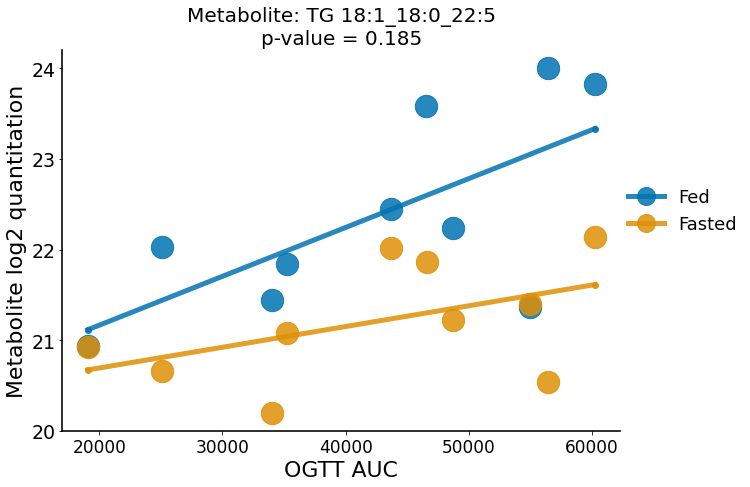

In [23]:
animal_ogtts = ap.loc[ap['lcms_sampled']].filter(regex='OGTT \(AUC\)')

# feature = random.sample(list(data.index), 1)[0]
# feature = 'm_548'
subset = data.loc[
    (~data['unique_id'].str.contains('unknown')) & \
#     (data['Type'] == 'lipid') & \
    (data['Type'] == 'metabolite') & \
#     (data['molec_class'] != 'TG') & \
    (data['qval_ogtt'] < 0.05) & \
    (data['qval_sampling:ogtt'] < 0.05)
]
# feature = data.loc[(~data['unique_id'].str.contains('unknown')) & (data['Type'] == 'lipid')]\
#               .sort_values('qval_sampling:ogtt').iloc[0].name
feature = 'l_762'  # m_123 = Glucose
# feature = subset.sort_values('qval_sampling:ogtt').iloc[0].name

fig, ax = plt.subplots()
fig.set_size_inches(10, 7)
fig.set_facecolor('white')
params = get_model_params(feature, data)

for bg_type, bg_color, offset in zip(['RBG', 'FBG'], [colors['RBG'], colors['FBG']], [-5, 5]):
    label = ('Fed' if bg_type == 'RBG' else 'Fasted')
    ax.plot(params[bg_type][0], params[bg_type][1], color=bg_color,
            linewidth=5, alpha=0.85, label=label)
    for animal in animals_used:
        gluc_tol = animal_tol[animal]
        animal_ogtt = animal_ogtts.loc[animal]
        df = data.loc[feature, data.filter(regex=str(animal)).filter(regex=bg_type).columns]
#         plt.scatter(np.array([animal_ogtt]*3) + offset, df, color=bg_color, alpha=0.85, s=200)
        plt.scatter(np.array([animal_ogtt]*1) + offset, df.mean(), color=bg_color, alpha=0.85, s=500)
plt.ylabel('Metabolite log2 quantitation', fontsize=22)
plt.yticks(range(round(plt.ylim()[0]), round(plt.ylim()[1])+1), fontsize=19)
plt.xlabel('OGTT AUC', fontsize=22)  # \nOral Glucose Tolerance Test Area Under Curve
plt.xticks(range(20000, 60001, 10000), fontsize=17)

interaction_pval = pval_text(data.loc[feature, qval_cross.name])
ogtt_pval = pval_text(data.loc[feature, qval_gtol.name])
# feature_pvalue = round(data.loc[feature, qval_cross.name], 3)
plt.title('Metabolite: ' + str(data.loc[feature, 'ID']) + \
#           f'\ninteraction term p-value {interaction_pval}' + \
#           f'\nglucose tolerance p-value {ogtt_pval}'
          f'\np-value {interaction_pval}', fontsize=20)

handles, labels = ax.get_legend_handles_labels()
handles = [x.set_marker('o') for x in handles]
plt.legend(loc=(1, 0.5), fontsize=18, markerscale=3, frameon=False)
# for ogtt_value in animal_ogtts.iloc[:, 0]:
#     plt.vlines(x=ogtt_value, ymin=ylim[0], ymax=ylim[1], color='gray', alpha=0.2)
sns.despine()
[x.set_linewidth(1.6) for x in ax.spines.values()];  # Set width of Spines 
# plt.savefig(r'..\reports\figures\3-5-0\glucose.svg', dpi=300, bbox_inches='tight', facecolor='white')
# plt.savefig(r'..\reports\figures\3-5-0\glucose.png', dpi=300, bbox_inches='tight', facecolor='white')

NameError: name 'ogtt' is not defined

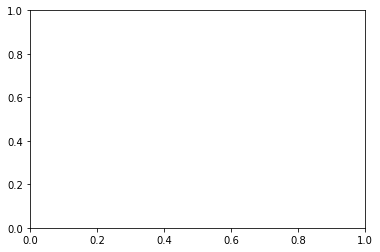

In [15]:
animal_ogtts = ap.loc[ap['lcms_sampled']].filter(regex='OGTT \(AUC\)')

# feature = random.sample(list(data.index), 1)[0]
feature = 'm_548'
# feature = data.loc[~(data['molec_class'].str.contains('unknown')) & \
#                    (data['Type'] == 'metabolite')] \
#               .sort_values(qval_cross.name).iloc[2] 
# print(feature['ID'])
# feature = feature.name
# print(feature)

fig, ax = plt.subplots()
fig.set_facecolor('white')
params = get_model_params(feature, ogtt)

for bg_type, bg_color, offset in zip(['RBG', 'FBG'], [colors['RBG'], colors['FBG']], [-5, 5]):
    ax.plot(params[bg_type][0], params[bg_type][1], label=bg_type, color=bg_color)
    for animal in animals_used:
        gluc_tol = animal_tol[animal]
        animal_ogtt = animal_ogtts.loc[animal]
        df = data.loc[feature, data.filter(regex=str(animal)).filter(regex=bg_type).columns]
        plt.scatter(np.array([animal_ogtt]*3) + offset, df, color=bg_color, alpha=0.85)
plt.ylabel('log2 feature abundance', fontsize=12)
plt.xlabel('OGTT (AUC)', fontsize=12)
feature_pvalue = round(data.loc[feature, qval_cross.name], 4)
plt.title(data.loc[feature, 'Proposed ID'] + f'\np-value = {feature_pvalue}', fontsize=14)
plt.legend(loc=(1, 0.5))
ylim = ax.get_ylim()
for ogtt_value in animal_ogtts.iloc[:, 0]:
    plt.vlines(x=ogtt_value, ymin=ylim[0], ymax=ylim[1], color='gray', alpha=0.2)
# plt.xticks(animal_ogtts.iloc[:, 0])
sns.despine()

In [26]:
animal_ogtts = ap.loc[ap['lcms_sampled']].filter(regex='OGTT \(AUC\)')

# feature = random.sample(list(data.index), 1)[0]
# feature = 'm_548'
feature = data.loc[~(data['Unique ID'].str.contains('unknown')) & \
                   (data['Type'] == 'metabolite')] \
              .sort_values(qval_gtol.name).iloc[10] 
print(feature['ID'])
feature = feature.name
print(feature)

fig, ax = plt.subplots()
fig.set_facecolor('white')
params = get_model_params(feature, ogtt)

for bg_type, bg_color, offset in zip(['RBG', 'FBG'], [colors['RBG'], colors['FBG']], [-5, 5]):
    ax.plot(params[bg_type][0], params[bg_type][1], label=bg_type, color=bg_color)
    for animal in animals_used:
        gluc_tol = animal_tol[animal]
        animal_ogtt = animal_ogtts.loc[animal]
        df = data.loc[feature, data.filter(regex=str(animal)).filter(regex=bg_type).columns]
        plt.scatter(np.array([animal_ogtt]*3) + offset, df, color=bg_color, alpha=0.85)
plt.ylabel('log2 feature abundance', fontsize=12)
plt.xlabel('OGTT (AUC)', fontsize=12)
feature_pvalue = round(data.loc[feature, qval_gtol.name], 4)
plt.title(data.loc[feature, 'Proposed ID'] + f'\np-value = {feature_pvalue}', fontsize=14)
plt.legend(loc=(1, 0.5))
ylim = ax.get_ylim()
for ogtt_value in animal_ogtts.iloc[:, 0]:
    plt.vlines(x=ogtt_value, ymin=ylim[0], ymax=ylim[1], color='gray', alpha=0.2)
# plt.xticks(animal_ogtts.iloc[:, 0])
sns.despine()

KeyError: 'Unique ID'

In [6]:
d = {'RBG': {}, 'FBG': {}}

for animal in animals_used:
    for df, bg_type in zip([f, r], ['FBG', 'RBG']):
        bg_type_animal_mean = df.filter(regex=str(animal)).mean(axis=1)
        d['RBG'][animal] = bg_type_animal_mean 
d

{'RBG': {1091: i
  l_0      23.966487
  l_1      24.912942
  l_2      23.413989
  l_3      27.350338
  l_4      22.522382
             ...    
  m_169    25.124559
  m_213    23.324871
  m_24     27.744507
  m_505    21.655395
  m_441    22.617104
  Length: 1727, dtype: float64,
  1093: i
  l_0      23.611918
  l_1      24.567604
  l_2      23.952991
  l_3      26.970232
  l_4      22.766641
             ...    
  m_169    25.198418
  m_213    22.464199
  m_24     27.636194
  m_505    21.183386
  m_441    22.558525
  Length: 1727, dtype: float64,
  1060: i
  l_0      23.840615
  l_1      25.054730
  l_2      24.048209
  l_3      26.942758
  l_4      23.111682
             ...    
  m_169    24.832177
  m_213    21.665979
  m_24     27.396343
  m_505    20.623551
  m_441    22.525861
  Length: 1727, dtype: float64,
  1062: i
  l_0      23.174288
  l_1      23.608273
  l_2      23.749417
  l_3      27.198735
  l_4      22.836285
             ...    
  m_169    24.855207
  m_213    23.623

In [34]:
# def get_model_params(feature, df): 
# #     params = ast.literal_eval(df.loc[feature]['full_model_params'])
#     interceptfbg = df.loc[feature, 'model_param_Intercept']
#     interceptrbg = interceptfbg + df.loc[feature, 'model_param_sampling[T.RBG]']
#     ogtt_param = df.loc[feature, 'model_param_ogtt']
#     sampling_ogtt_cross_param = df.loc[feature, 'model_param_sampling[T.RBG]:ogtt']
    
#     minfbg = interceptfbg + ogtt_param * min_ogtt
#     minrbg = interceptrbg + ogtt_param * min_ogtt + sampling_ogtt_cross_param * min_ogtt
#     maxfbg = interceptfbg + ogtt_param * max_ogtt
#     maxrbg = interceptrbg + ogtt_param * max_ogtt + sampling_ogtt_cross_param * max_ogtt
    
#     return {'RBG': [[min_ogtt, max_ogtt], [minrbg, maxrbg]],
#             'FBG': [[min_ogtt, max_ogtt], [minfbg, maxfbg]]}  
# test = get_model_params('l_648', data)
# test